# Step 1. 데이터 수집하기
이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있다. 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있다.

In [3]:
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from importlib.metadata import version
import tensorflow
import summa
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


전체 샘플 수는 98401이고 headlines와 text 두개의 컬럼만 가진 데이터이며 text의 내용이 요약된 것이 headlines이라는 것을 알 수 있다. 인공 신경망을 통해 Text 시퀀스를 입력받으면, headlines 시퀀스를 예측하도록 인공 신경망을 훈련시켜 볼 것이다.

In [4]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))
data.sample(10)

전체 샘플수 : 98401


,headlines,text
44525,Ranveer talks about wearing skirt in live chat...,During a live chat with Priyanka Chopra on Ins...
84165,Sisodia gave wrong facts on students' success:...,The education department has said that Delhi D...
24867,Only 35 goods left in 28% GST slab from 226 at...,The GST Council has pruned the 28% slab by cut...
79961,Funny how one wrong word can screw your career...,"Tiger Shroff, who was criticised for referring..."
35174,Inspectors to be given access to Syria chemica...,Inspectors from the Organisation for the Prohi...
55640,Photo of owl climbing branch wins comedy wildl...,A photograph showing an owl trying to climb a ...
80861,White House strongly condemns Amarnath terror ...,The White House has strongly condemned the ter...
52011,Jews in India have never witnessed anti-Semiti...,Israeli PM Benjamin Netanyahu on Monday said t...
98032,'Modi Magic' lock on defeated SP minister's house,After the BJP swept Uttar Pradesh Assembly ele...
33228,Hope new team will work better: J&K CM on Cabi...,Following a reshuffle of the Jammu and Kashmir...


# Step 2. 데이터 전처리하기

 빈칸으로 존재하는 null 데이터, 의미는 같지만 다른 식으로 작성된 글 같은 중복 항목과 같은 학습할 때 방해가 되는 데이터를 먼저 제거할 것이다.

먼저 중복 샘플 유무를 확인한다. 중복을 제외한다면 text에는 98,360개, headlines에는 98,280개의 유니크한 데이터가 존재한다.

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


drop_duplicates()를 사용하여 중복 샘플을 제거하여 전체 샘플 수는 98,360개가 남는다.

In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


여전히 Null 값 한 개가 어딘가 남아있을 수 있기에 데이터에 Null 값이 남아있는지 확인한다. 이 데이터셋에는 Null 값이 없으므로 dropna() 함수 사용을 하지 않아도 된다!

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


텍스트 정규화를 위한 사전(dictionary)을 가져온다.

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재하는 불용어(stopwords)를 제거한다. 이것은 자연어 처리의 성능을 높이는 방법 중 하나이다. 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 것이다.

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 headlines 전처리할 때는 호출하지 않는다. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 headlines에는 남아 있는 게 더 좋을 것이기에 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가한다.

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

예시를 한번 확인해보자. 불용어가 제외된 텍스트 전처리 결과를 볼 수 있다!

In [11]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


훈련 데이터 전체에 대해서 전처리를 수행해본다. text의 경우에는 불용어를 제거하고, headlines의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 해요. 먼저 text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해본다.

In [12]:
# 전체 Text 데이터에 대한 전처리 : 굉장히 오래걸림.... 코드 확인 또 확인 후 돌리기
clean_text = []

for sentence in data["text"]:
    clean_text.append(preprocess_sentence(sentence, remove_stopwords=True))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣고 전처리 진행한다.

In [13]:
# 전체 headlines 데이터에 대한 전처리 
clean_headlines = []

for sentence in data["headlines"]:
    clean_headlines.append(preprocess_sentence(sentence, remove_stopwords=False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋다. 보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장한다. 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체한다.

In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

필요 없는 단어를 모두 솎아낸 데이터를 만들었으니 훈련에 사용할 샘플의 최대 길이를 정해준다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


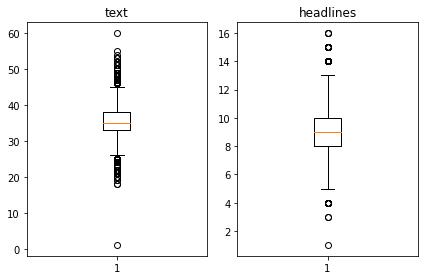

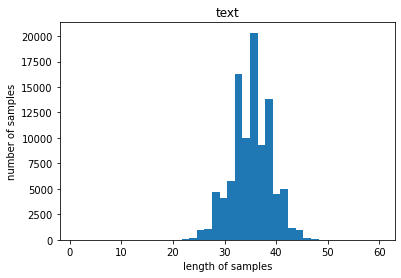

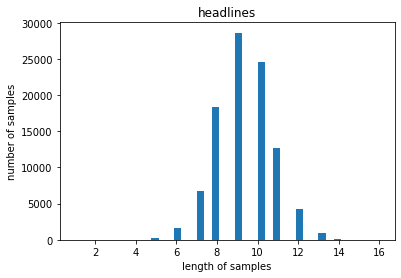

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어준다.

In [16]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

텍스트의 최대 길이와 헤드라인의 최대 길이 값을 변경해보면서 테스트해봤는데 40, 11이 적당한 비율값이 나오는 거 같아서 이렇게 설정한다.

In [17]:
text_max_len = 40
headlines_max_len = 11

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


text와 headlines를 담고 있는 data 데이터프레임을 위에서 임의로 정의한 text_max_len과 headlines_max_len의 길이보다 큰 샘플을 제외한다.

In [18]:
data = data[data['text'].apply(lambda t: len(t.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda t: len(t.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가해야 한다.
시작 토큰은 sostoken, 종료 토큰은 eostoken이라 하고 앞, 뒤로 추가한다.
디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정한다.

In [19]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


훈련 데이터와 테스트 데이터를 분리한다. encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어준 후 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해준다.

In [20]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블


테스트 데이터의 개수를 이용해 전체 데이터를 양분한다.
훈련 데이터와 테스트 데이터가 각각 68675, 17168개로 분리된 것을 확인할 수 있다.

In [21]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

[20371 41367 10881 ... 14647 27087 75341]
테스트 데이터의 수 : 17168
훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 줘야 한다. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요한데 이 과정을 단어 집합(vocabulary) 을 만든다고 한다. 
Keras의 토크나이저를 사용하여 입력된 훈련 데이터로부터 단어 집합을 만든다.

In [22]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있다. 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외한다. threshold = 10으로 정했는데 등장 빈도 수가 10번 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해본다.

In [25]:
threshold = 10
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64644
등장 빈도가 9번 이하인 희귀 단어의 수: 47605
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17039
단어 집합에서 희귀 단어의 비율: 73.6417919683188
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.95077172071381


등장 빈도가 threshold 값인 10회 미만인 단어들이 집합에서 무려 70% 이상을 차지하는데 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 4.95%밖에 되지 않기 때문에 이 단어들을 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거한다. src_vocab 단어수는 임의로 17039로 설정하였다. 

In [26]:
src_vocab = 17039
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

현재 단어 집합의 크기를 17039으로 제한했으니까 이제 17039이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.

In [27]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[31, 22, 142, 18, 7040, 1725, 1143, 1967, 3498, 1, 268, 1107, 339, 3346, 2748, 2818, 36, 2772, 1792, 4499, 2987, 2136, 2057, 1725, 705, 51, 1107, 851, 6, 1, 51, 6, 117, 2363, 14107, 176, 194], [49, 407, 87, 2879, 4421, 517, 75, 2530, 690, 225, 8354, 254, 163, 973, 13116, 13, 6, 546, 1351, 562, 8354, 33, 407, 84, 11855, 13117, 12240, 4192, 27, 1, 117, 504, 889], [1102, 1184, 3143, 1250, 184, 15, 3194, 3302, 1, 2, 3573, 1548, 237, 1417, 51, 2433, 7, 2626, 618, 42, 33, 70, 331, 619, 457, 184, 15, 9384, 4255, 3302, 1, 8835, 1184, 24, 671, 928, 2127]]


headlines 데이터에 대해서도 동일한 작업을 수행한다. 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산한다.

In [28]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되어서 이는 tar_tokenizer.word_index에 저장되어 있다. 등장 빈도수가 10회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해본다.

In [29]:
threshold = 10
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28435
등장 빈도가 9번 이하인 희귀 단어의 수: 21379
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7056
단어 집합에서 희귀 단어의 비율: 75.1855108141375
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.9729412965916335


요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않는다. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나오고 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있게 된다.
input은 1로 시작하고 target은 2로 끝나는 리스트가 생성된다.

In [30]:
tar_vocab = 7100
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1567, 12, 5670, 96, 951, 180, 3, 2346, 51, 2926], [1, 194, 3, 213, 2927, 44, 531, 4, 291, 5950], [1, 8, 74, 55, 2502, 3, 1496, 64, 2205, 7, 1152], [1, 40, 3166, 6, 2094, 6657, 3, 22, 116, 5, 1153], [1, 2057, 297, 1774, 23, 3, 60, 27, 4, 4410, 1568]]
target
decoder  [[1567, 12, 5670, 96, 951, 180, 3, 2346, 51, 2926, 2], [194, 3, 213, 2927, 44, 531, 4, 291, 5950, 2], [8, 74, 55, 2502, 3, 1496, 64, 2205, 7, 1152, 2], [40, 3166, 6, 2094, 6657, 3, 22, 116, 5, 1153, 2], [2057, 297, 1774, 23, 3, 60, 27, 4, 4410, 1568, 2]]


요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장하고 샘플들은 모두 삭제한다.

In [31]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17167
테스트 레이블의 개수 : 17167


서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해준다. 아까 정해두었던 최대 길이로 패딩해주고 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰준다.

In [65]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# Step 3. 어텐션 메커니즘 사용하기

함수형 API를 이용해서 인코더를 설계한다. 임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의한다.

In [35]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

디코더의 출력층에서는 headlines의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 한다. 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용한다.
디코더의 출력층의 성능을 높히기 위해 어텐션 메커니즘을 사용한다.

In [36]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [40]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 128)      2180992     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 40, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있다. 
patience의 값을 3으로 맞추고 batch_size를 64로 설정하였다.

In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=64, callbacks=[es], epochs=50)

Epoch 1/50
1074/1074 [==============================] - 36s 29ms/step - loss: 5.2550 - val_loss: 4.9370
Epoch 2/50
1074/1074 [==============================] - 31s 29ms/step - loss: 4.8153 - val_loss: 4.6845
Epoch 3/50
1074/1074 [==============================] - 31s 29ms/step - loss: 4.5610 - val_loss: 4.4896
Epoch 4/50
1074/1074 [==============================] - 30s 28ms/step - loss: 4.3737 - val_loss: 4.3480
Epoch 5/50
1074/1074 [==============================] - 31s 29ms/step - loss: 4.2300 - val_loss: 4.2495
Epoch 6/50
1074/1074 [==============================] - 31s 28ms/step - loss: 4.1104 - val_loss: 4.1725
Epoch 7/50
1074/1074 [==============================] - 31s 28ms/step - loss: 4.0255 - val_loss: 4.1204
Epoch 8/50
1074/1074 [==============================] - 31s 28ms/step - loss: 3.9452 - val_loss: 4.0780
Epoch 9/50
1074/1074 [==============================] - 31s 28ms/step - loss: 3.8738 - val_loss: 4.0276
Epoch 10/50
1074/1074 [==============================] - 31s 29m

훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화한다.

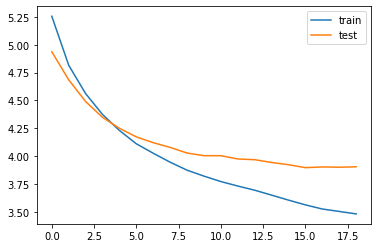

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 4. 실제 결과와 요약문 비교하기

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비한다.

In [45]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print(len(src_index_to_word))
print(len(tar_word_to_index))
print(len(tar_index_to_word))

64644
28436
28436


훈련훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 전체를 함께 출력한다.

In [46]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계한다.

In [47]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 생성한다.

In [51]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하기에 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만든다. 함수를 만들 때, text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만든다.

In [52]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if (i == 2):  # End token #2 = eostoken
            break
        if (i!=0 and i != 1):  # Exclude padding and start token #1 = sostoken
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해본다.. 음 결과가 그렇게까진 나쁘진 않은 것 같다..

In [54]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : australian man pulled police allegedly driving speed limit minutes bought porsche suv allegedly filmed phone ride vehicle seized police days man expected charged speeding using phone driving 
실제 요약 : porsche gets seized by police minutes after owner buys it 
예측 요약 :  man fined for driving driving to sell car


원문 : failed bid acquire fortis healthcare capital manipal health reportedly talks jointly acquire majority stake gurugram based hospital operator heart surgeon naresh family co founder sunil stake company manipal likely offer valuation crore reports added 
실제 요약 : in talks to buy after failed fortis bid 
예측 요약 :  to buy stake in


원문 : suhana khan appear guest opening episode koffee karan sixth season formally introduced public making bollywood debut per reports earlier reports suggested shah rukh khan kajol rani mukerji appear first guests celebrate th anniversary kuch kuch hota hai 
실제 요약 : suhana khan to be first guest on koffee with karan report 
예측 요약 :  kapil sharma to

# Step 5. Summa을 이용해서 추출적 요약해보기

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행할 수 있기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다.

In [55]:
from summa.summarizer import summarize

file = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
file.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


seq2seq Summa의 요약 결과 비교해보았다. 더 나은 결과인지는 전혀 모르겠다..

In [66]:
for i in range(50,100):
    sentence = file.loc[i, 'text']
    print("원문 :", sentence)
    print('---------')
    print("실제 요약 :", file.loc[i, 'headlines'])
    print("seq2seq :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("summa :", summarize(sentence, words=20))
    print('===========')
    print("\n")


원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
---------
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
seq2seq :  man fined for driving driving to sell car
summa : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its posi

핵심 단어가 포함된 결과가 이렇게 보여지는 것을 알 수 있다!

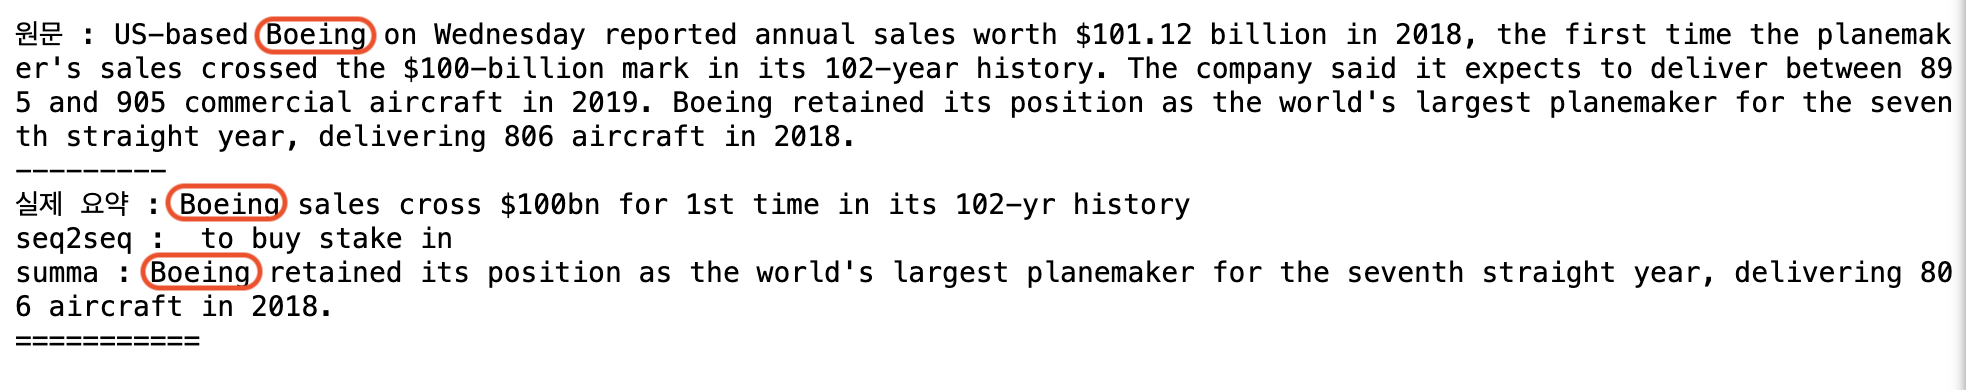

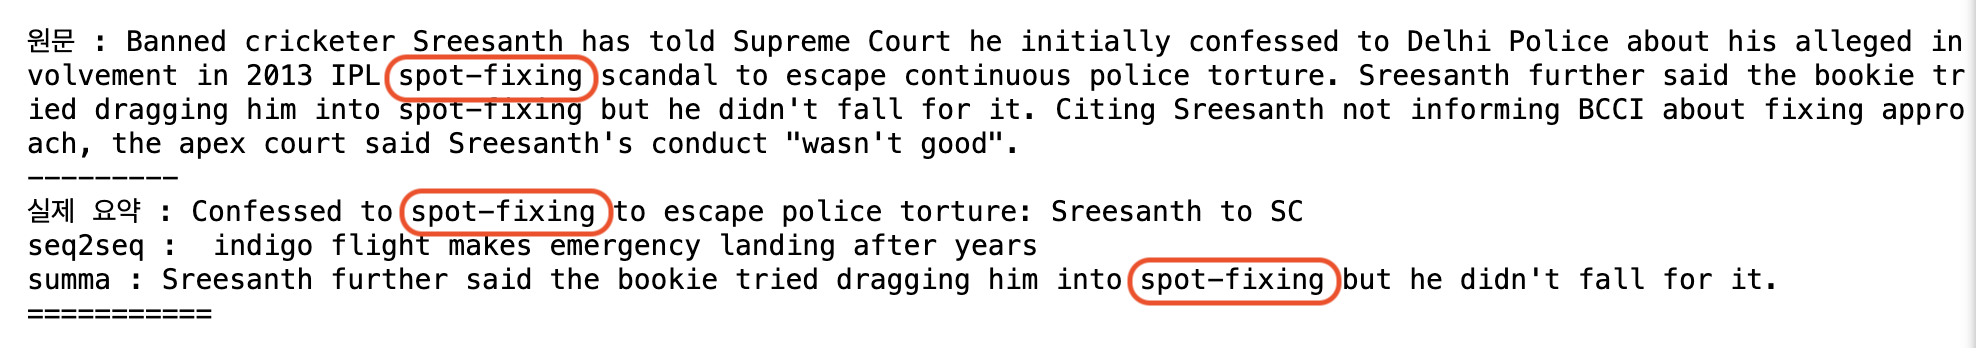

In [74]:
from IPython.display import Image, display

img_path1 = os.getenv('HOME') + '/aiffel/project/1.png'
img_path2 = os.getenv('HOME') + '/aiffel/project/2.png'

img1 = Image(filename=img_path1)
img2 = Image(filename=img_path2)

display(img1)
display(img2)



##회고


#서론 

뉴스 기사 데이터를 사용해서 텍스트를 정규화와 불용어 제거와 같은 전처리를 하고 어텐션 메커니즘을 사용한 seq2seq를 사용하여 학습시킨 후 학습을 통해 얻은 추상적 요약의 결과를 비교하고 Summa을 이용해서 추출적 요약을 하는 것이 이번 과제의 목표이다.

#개발 과정 

NLTK(Natural Language Toolkit)의 불용어(stopwords)를 사용하여 학습할 때 방해가 되는 데이터를 먼저 제거 후 텍스트 정규화를 위한 사전(dictionary)을 가져와 자연어 처리시에 도움되지 않는 불용어를 샘플에서 제거한다. 필요없는 단어들이 솎아진 데이터로 훈련에 사용할 샘플의 최대 길이를 설정해주고 훈련 데이터와 샘플의 길이를 입력시 데이터의 몇 %가 해당하는 지 계산되는 함수를 설정한다. seq2seq 훈련을 위해 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가하고 훈련데이터와 테스트 데이터를 분리하여 정수 시퀀스를 만들어준 후 샘플 순서를 정의해준다. 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꿔준 후 Keras에 Tokenizer를 사용하여 단어 집합을 만든다. 단어 등장 빈도수가 낮은 단어들을 인코딩 과정과 훈련 데이터에서 제외시켜준 후 sostoken와 eostoken를 추가하여 리스트를 생성 후 같은 길이로 맞춰주는 패딩 작업을 해준다. 그리고 함수형 API를 이용해서 인코더와 디코더를 설계하여 적절한 하이퍼파라미터를 조절하여 학습을 시킨 후 훈련 데이터와 검증 데이터의 손실의 과정을 시각화한다. 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로 어텐션 메커니즘으로 출력하여 정수 시퀀스를 텍스트 시퀀스로 변환시킨다. 그리고 나온 테스트 데이터들에 대한 실제 요약과 예측된 요약을 비교해본다.

#결과 및 토론 

원문, 실제 요약, seq2seq 그리고 summa의 결과를 확인해보았을 때 원문과 실제 요약의 결과는 생각보다 나쁘지 않았다. seq2seq 결과는 전처리의 문제인건지 하이퍼파라미터의 조절값이 문제인건진 잘 모르겠으나 말이 되지 않게 출력되는 결과들이 종종 보였다. summa를 사용했을 때에는 나오지 않는 결과도 있었는데 대부분의 문장들이 적절하게 요약되어 나온 것을 확인할 수 있었다.


#배운 점 및 회고 

이번 과제를 수행하는데에 있어서 sostoken와 eostoken을 하는 데에 이해가 많이 필요했으며 여전히 인코딩 디코딩 해주는 작업에 대해 좀 더 공부가 많이 필요하다고 느꼈다. 어텐션 메커니즘을 사용한 seq2seq를 사용하여 학습된 결과를 봤을 때 정말 신기했다. 그리고 정확하게 어떤 하이퍼파라미터를 조절해야 값이 변경되는건지도 궁금했고 src_vocab의 값을 어떻게 줘야할 지 몰라서 그냥 희귀 단어를 제외시킬 경우의 단어 집합의 크기를 넣었고, tar_vocab의 값도 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기보다 조금 높은 7100으로 잡았는데 이 부분에 대해 더 학습이 필요할 것 같다.